In [12]:
import numpy as np
import pandas as pd
import nltk
import string
#import fasttext
#import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [3]:
rawData = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

In [17]:
textProcessing = rawData[['job_title','location']].copy()

In [63]:
textProcessing['tokenized'] = textProcessing['job_title'].apply(word_tokenize)
textProcessing['tokenizedLoc'] = textProcessing['location'].apply(word_tokenize)

In [64]:
textProcessing['lower'] = textProcessing['tokenized'].apply(lambda x: [word.lower() for word in x])
textProcessing['lowerLoc'] = textProcessing['tokenizedLoc'].apply(lambda x: [word.lower() for word in x])

In [65]:
textProcessing['no_punc'] = textProcessing['lower'].apply(lambda x: [word for word in x if word not in string.punctuation])
textProcessing['no_puncLoc'] = textProcessing['lowerLoc'].apply(lambda x: [word for word in x if word not in string.punctuation])

In [71]:
stop_words = set(stopwords.words('english'))
textProcessing['stopwords_removed'] = textProcessing['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
stop_words.add('area')
stop_words.add('greater')
textProcessing['stopwords_removedLoc'] = textProcessing['no_puncLoc'].apply(lambda x: [word for word in x if word not in stop_words])

In [34]:
textProcessing['pos_tags'] = textProcessing['stopwords_removed'].apply(nltk.tag.pos_tag)

In [37]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
textProcessing['wordnet_pos'] = textProcessing['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [39]:
wnl = WordNetLemmatizer()
textProcessing['lemmatized'] = textProcessing['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

In [124]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="MyApp")

def getCoords(textLoc):
    loc = ' '.join(textLoc)
    location = geolocator.geocode(loc)
    return (location.latitude, location.longitude)

textProcessing['latLong'] = textProcessing['stopwords_removedLoc'].apply(getCoords)

In [119]:
processed = textProcessing[['stopwords_removedLoc','lemmatized', 'latLong']].copy()

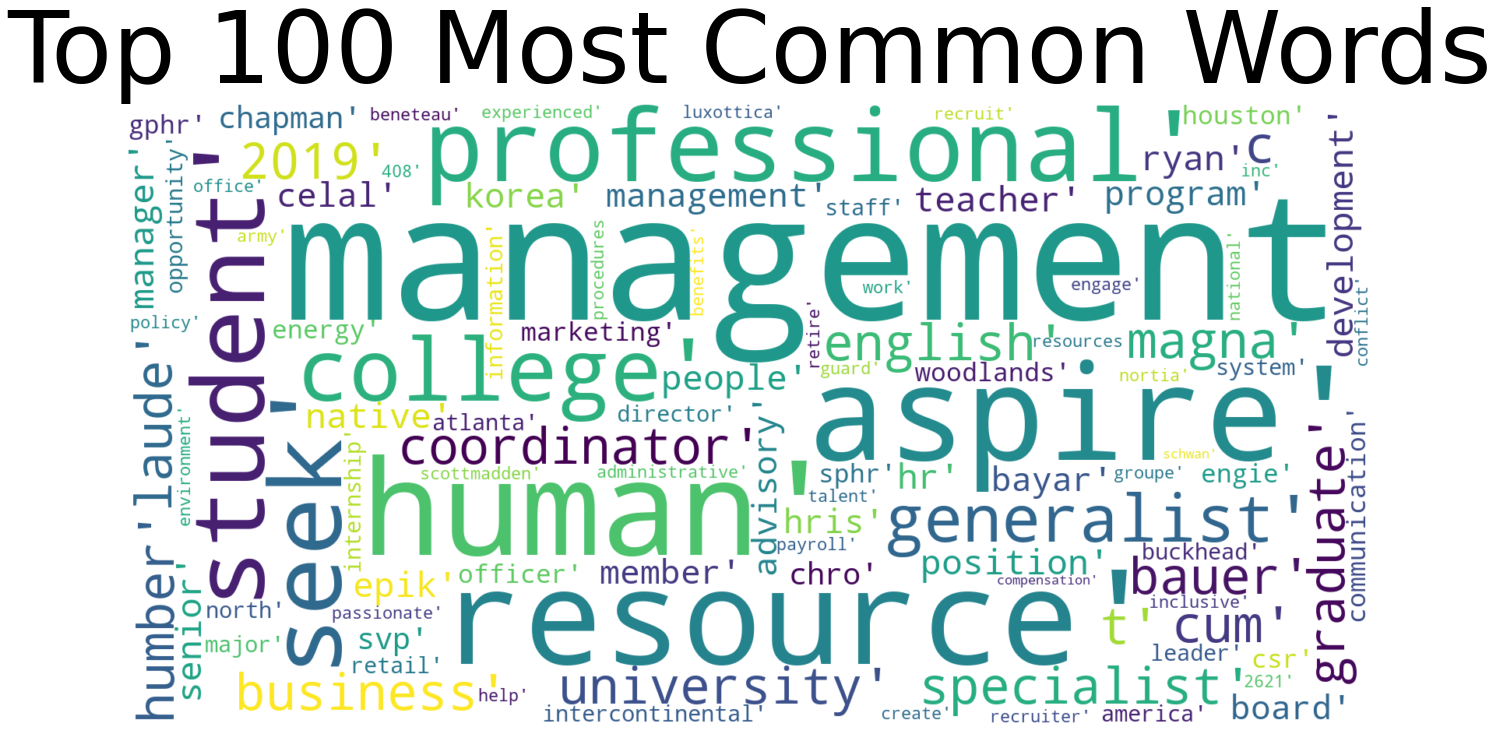

In [123]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

allwords = []
for wordlist in processed['lemmatized']:
    allwords += wordlist

mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

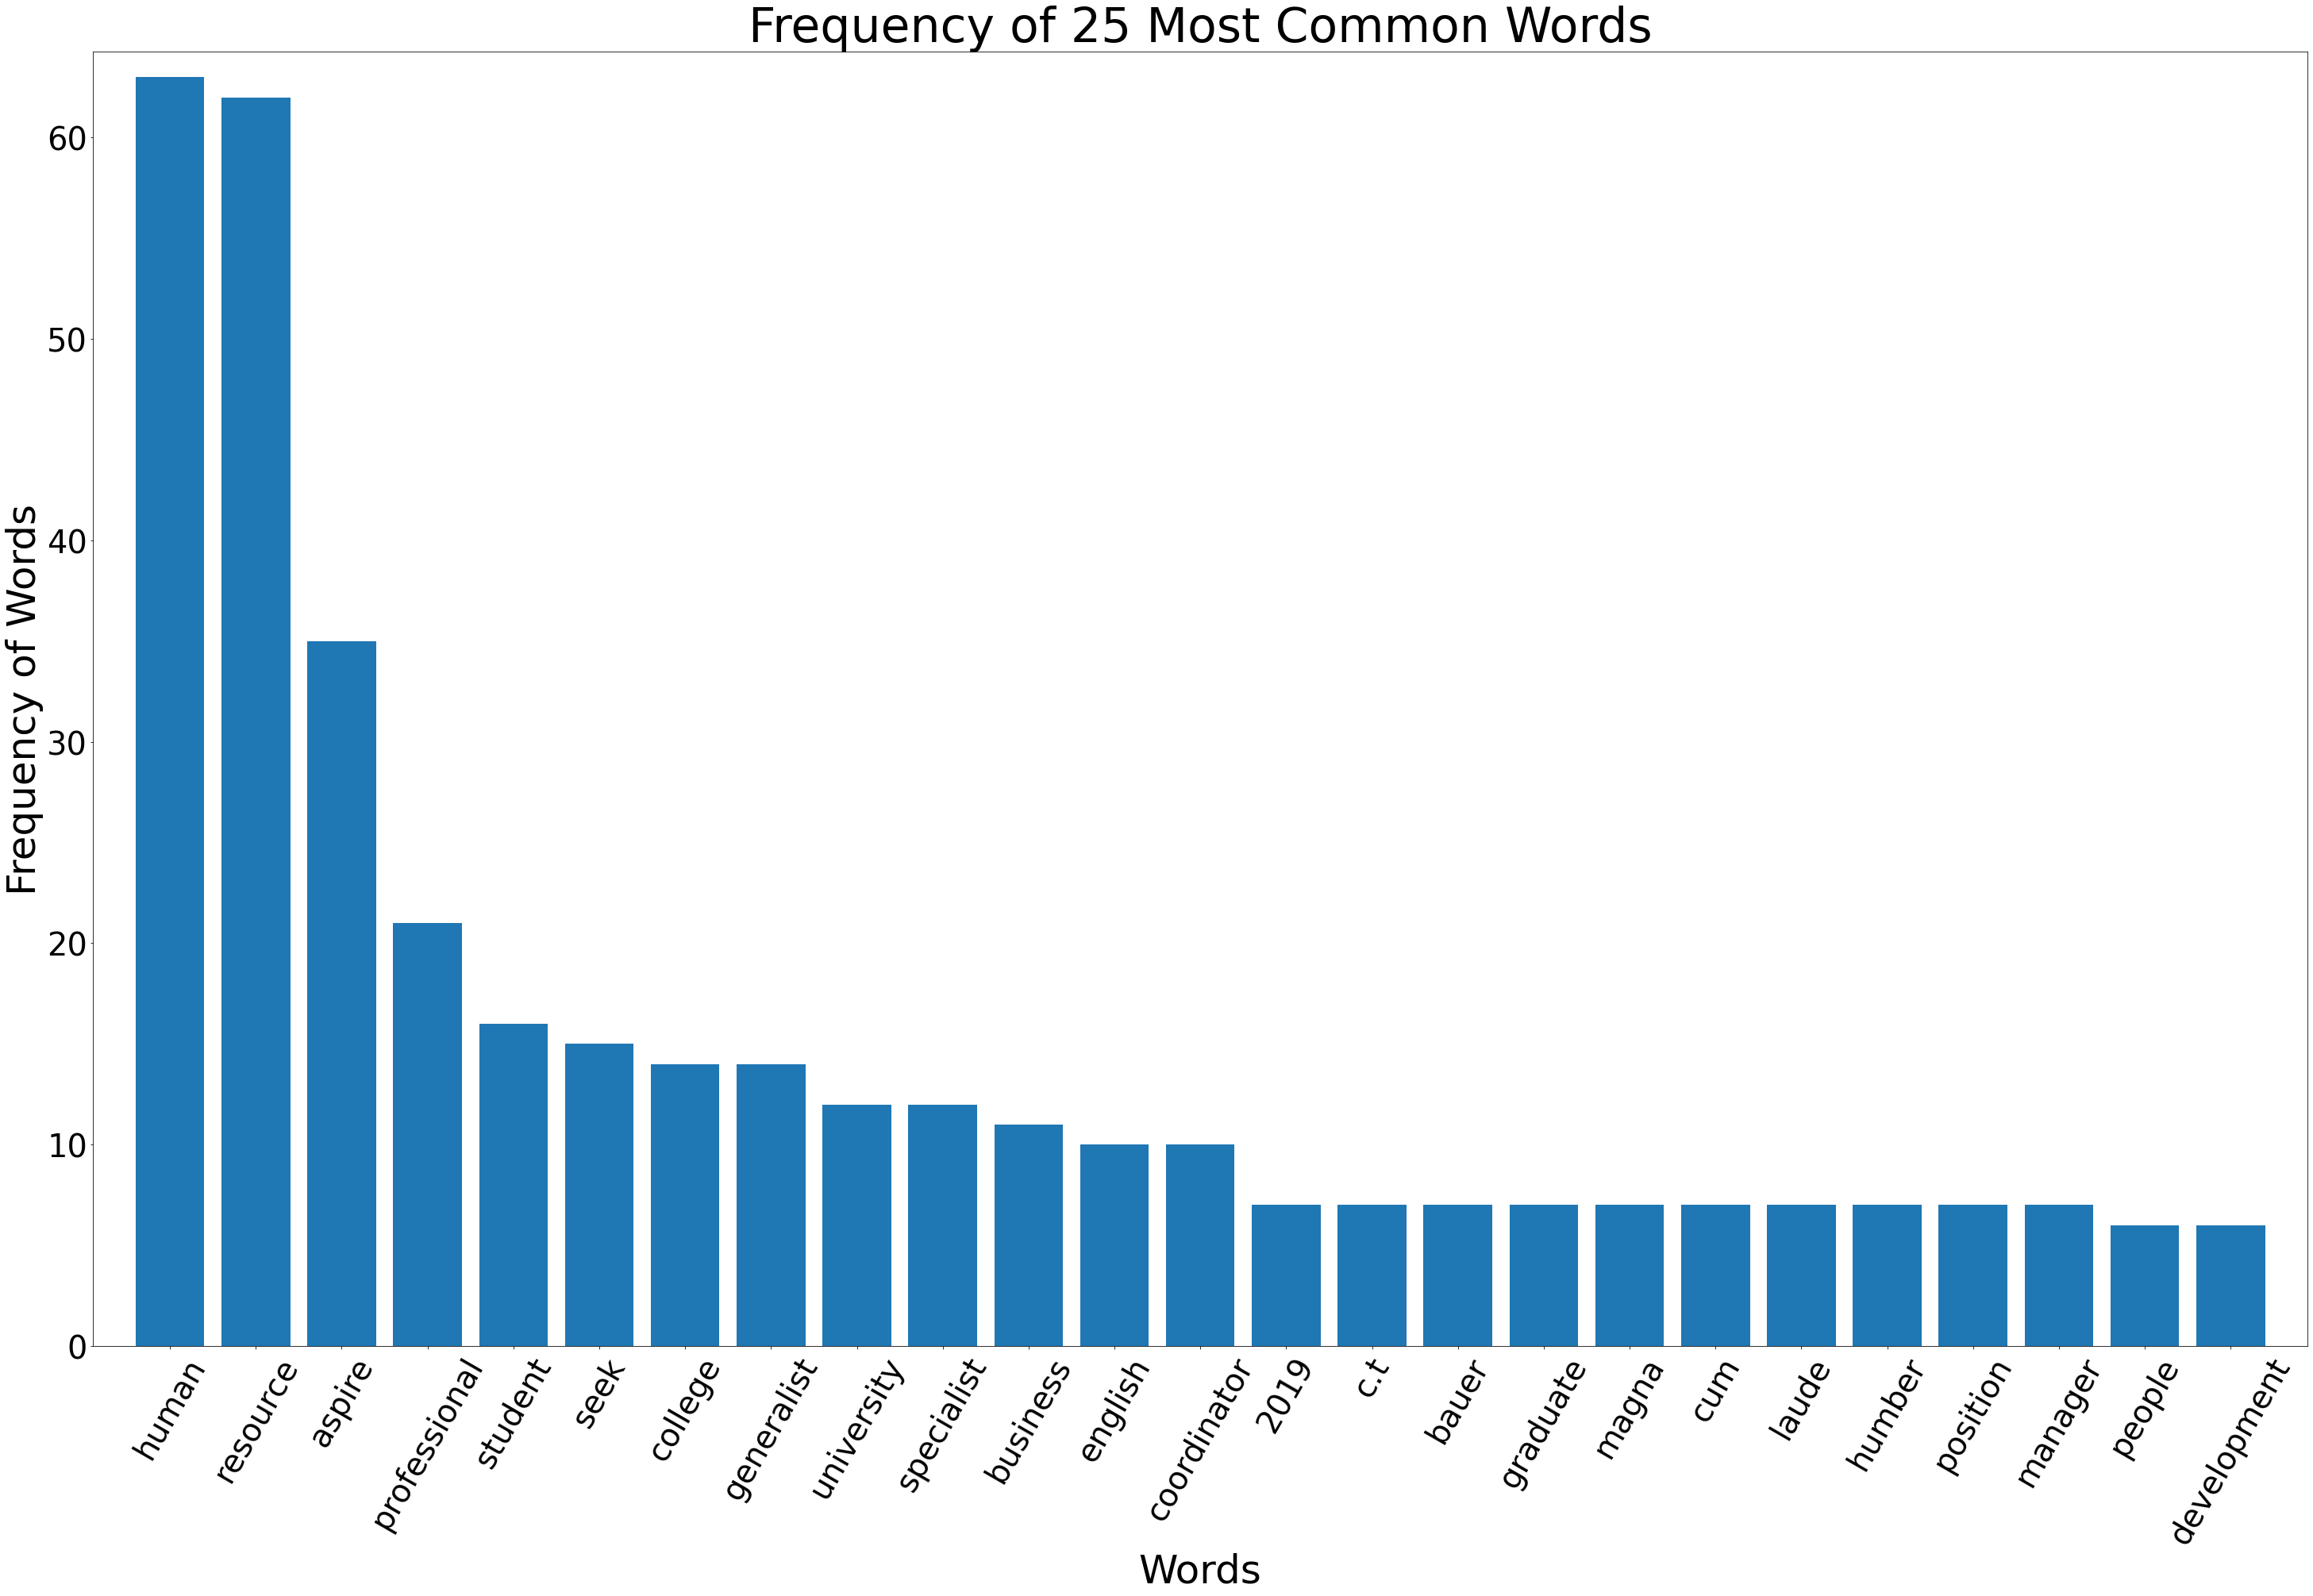

In [122]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [126]:
processed['lemma_str'] = [' '.join(map(str,l)) for l in processed['lemmatized']]
processed

,stopwords_removedLoc,lemmatized,latLong,lemma_str
0,"[houston, texas]","[2019, c.t, bauer, college, business, graduate...","(29.7589382, -95.3676974)",2019 c.t bauer college business graduate magna...
1,[kanada],"[native, english, teacher, epik, english, prog...","(61.0666922, -107.991707)",native english teacher epik english program korea
2,"[raleigh-durham, north, carolina]","[aspire, human, resource, professional]","(35.880361449999995, -78.78723821716514)",aspire human resource professional
3,"[denton, texas]","[people, development, coordinator, ryan]","(33.1838787, -97.1413417)",people development coordinator ryan
4,"[i̇zmir, türkiye]","[advisory, board, member, celal, bayar, univer...","(38.4224548, 27.1310699)",advisory board member celal bayar university
...,...,...,...,...
99,"[cape, girardeau, missouri]","[aspire, human, resource, manager, graduating,...","(37.3034933, -89.5230357)",aspire human resource manager graduating may 2...
100,"[raleigh-durham, north, carolina]","[human, resource, generalist, loparex]","(35.880361449999995, -78.78723821716514)",human resource generalist loparex
101,"[new, york, city]","[business, intelligence, analytics, traveler]","(40.7127281, -74.0060152)",business intelligence analytics traveler
102,"[los, angeles]","[always, set, success]","(34.0536909, -118.242766)",always set success


In [129]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

tf_vectorizer = CountVectorizer(max_df=0.9, min_df=3, max_features=5000)
tf = tf_vectorizer.fit_transform(processed['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

,2019,advisory,aspire,atlanta,bauer,bayar,board,buckhead,business,celal,...,ryan,seek,senior,specialist,sphr,student,svp,teacher,university,woodlands
0,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
university student coordinator chapman board intercontinental bayar member advisory celal
Topic 1:
college aspire resource human humber generalist student magna bauer cum
Topic 2:
human student resource aspire generalist college humber management major manager
Topic 3:
aspire college student humber human generalist position seek resource development
Topic 4:
business human resource professional aspire 2019 magna bauer cum laude
Topic 5:
communication csr sphr houston marketing gphr woodlands officer svp chro
Topic 6:
specialist hr senior manager business resource human teacher intercontinental bayar
Topic 7:
english native teacher korea program epik specialist senior hr student
Topic 8:
resource human aspire seek professional position generalist specialist opportunity hris
Topic 9:
gphr communication sphr svp energy csr houston officer engie chro


In [135]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df = 3, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(processed['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,2019,advisory,aspire,atlanta,bauer,bayar,board,buckhead,business,celal,...,ryan,seek,senior,specialist,sphr,student,svp,teacher,university,woodlands
0,0.339352,0.000000,0.196560,0.0,0.339352,0.000000,0.000000,0.0,0.300858,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0
2,0.000000,0.000000,0.524750,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.514953,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.423208,0.000000,0.0,0.000000,0.423208,0.423208,0.0,0.000000,0.423208,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.323226,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.000000,0.000000,0.274254,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.381672,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
100,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
101,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
102,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [136]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
professional resource human aspire manager major specialist director management buckhead
Topic 1:
generalist humber student college aspire resource human specialist hris director
Topic 2:
specialist hr senior aspire resource human business manager bauer graduate
Topic 3:
business 2019 bauer cum graduate laude magna college aspire professional
Topic 4:
coordinator ryan development people atlanta buckhead intercontinental resource human senior
Topic 5:
university student chapman management manager internship business major aspire hr
Topic 6:
seek position human resource opportunity hris generalist manager management internship
Topic 7:
english program korea epik native teacher management major manager business
Topic 8:
woodlands csr officer houston gphr engie marketing energy communication chro
Topic 9:
member bayar advisory celal board university gphr graduate cum epik


In [138]:
nmf_topic_values = nmf.transform(tfidf)
processed['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
processed['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'Topic 0 - LDA', 1: 'Topic 1 - LDA', 2: 'Topic 2 - LDA', 3: 'Topic 3 - LDA', 4: 'Topic 4 - LDA', 
             5: 'Topic 5 - LDA', 6: 'Topic 6 - LDA', 7: 'Topic 7 - LDA', 8: 'Topic 8 - LDA', 9: 'Topic 9 - LDA'}
processed['lda_topics'] = processed['lda_topics'].map(lda_remap)
nmf_remap = {0: 'Topic 0 - NMF', 1: 'Topic 1 - NMF', 2: 'Topic 2 - NMF', 3: 'Topic 3 - NMF', 4: 'Topic 4 - NMF', 
             5: 'Topic 5 - NMF', 6: 'Topic 6 - NMF', 7: 'Topic 7 - NMF', 8: 'Topic 8 - NMF', 9: 'Topic 9 - NMF'}
processed['nmf_topics'] = processed['nmf_topics'].map(nmf_remap)

In [139]:
processed

,stopwords_removedLoc,lemmatized,latLong,lemma_str,nmf_topics,lda_topics
0,"[houston, texas]","[2019, c.t, bauer, college, business, graduate...","(29.7589382, -95.3676974)",2019 c.t bauer college business graduate magna...,Topic 3 - NMF,Topic 4 - LDA
1,[kanada],"[native, english, teacher, epik, english, prog...","(61.0666922, -107.991707)",native english teacher epik english program korea,Topic 7 - NMF,Topic 7 - LDA
2,"[raleigh-durham, north, carolina]","[aspire, human, resource, professional]","(35.880361449999995, -78.78723821716514)",aspire human resource professional,Topic 0 - NMF,Topic 8 - LDA
3,"[denton, texas]","[people, development, coordinator, ryan]","(33.1838787, -97.1413417)",people development coordinator ryan,Topic 4 - NMF,Topic 4 - LDA
4,"[i̇zmir, türkiye]","[advisory, board, member, celal, bayar, univer...","(38.4224548, 27.1310699)",advisory board member celal bayar university,Topic 9 - NMF,Topic 0 - LDA
...,...,...,...,...,...,...
99,"[cape, girardeau, missouri]","[aspire, human, resource, manager, graduating,...","(37.3034933, -89.5230357)",aspire human resource manager graduating may 2...,Topic 6 - NMF,Topic 8 - LDA
100,"[raleigh-durham, north, carolina]","[human, resource, generalist, loparex]","(35.880361449999995, -78.78723821716514)",human resource generalist loparex,Topic 1 - NMF,Topic 8 - LDA
101,"[new, york, city]","[business, intelligence, analytics, traveler]","(40.7127281, -74.0060152)",business intelligence analytics traveler,Topic 3 - NMF,Topic 4 - LDA
102,"[los, angeles]","[always, set, success]","(34.0536909, -118.242766)",always set success,Topic 0 - NMF,Topic 0 - LDA


/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

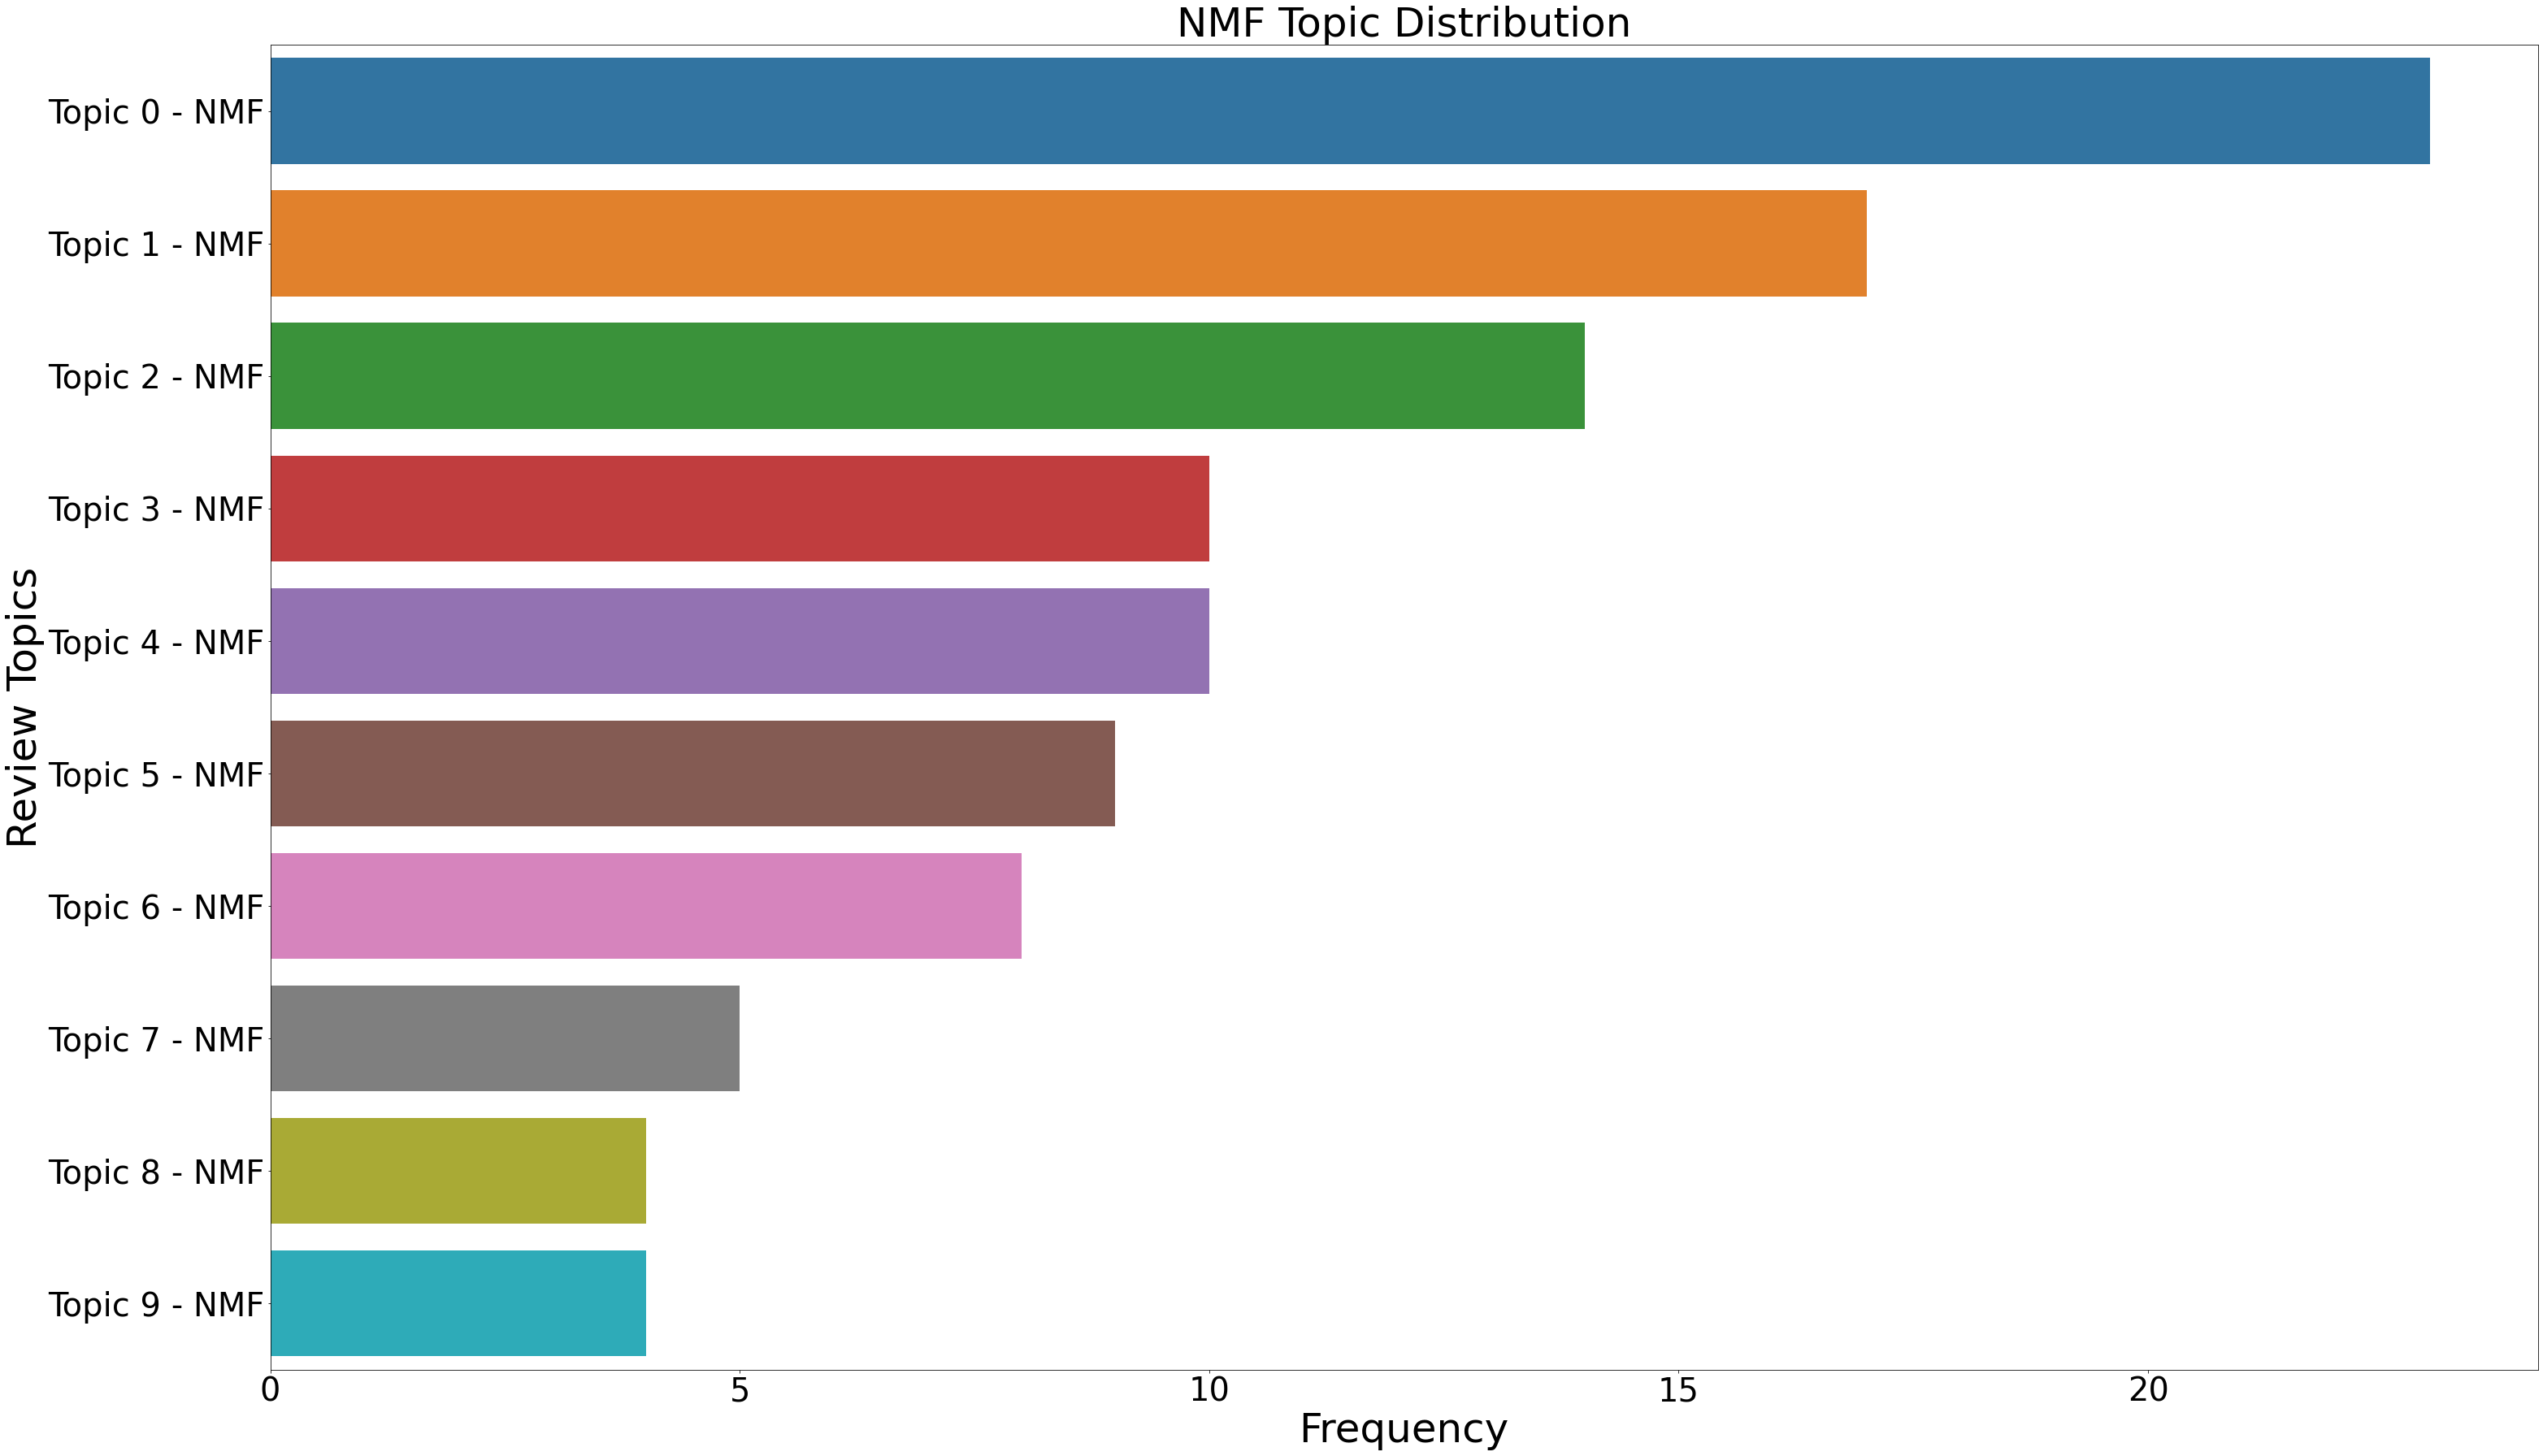

In [140]:
nmf_x = processed['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

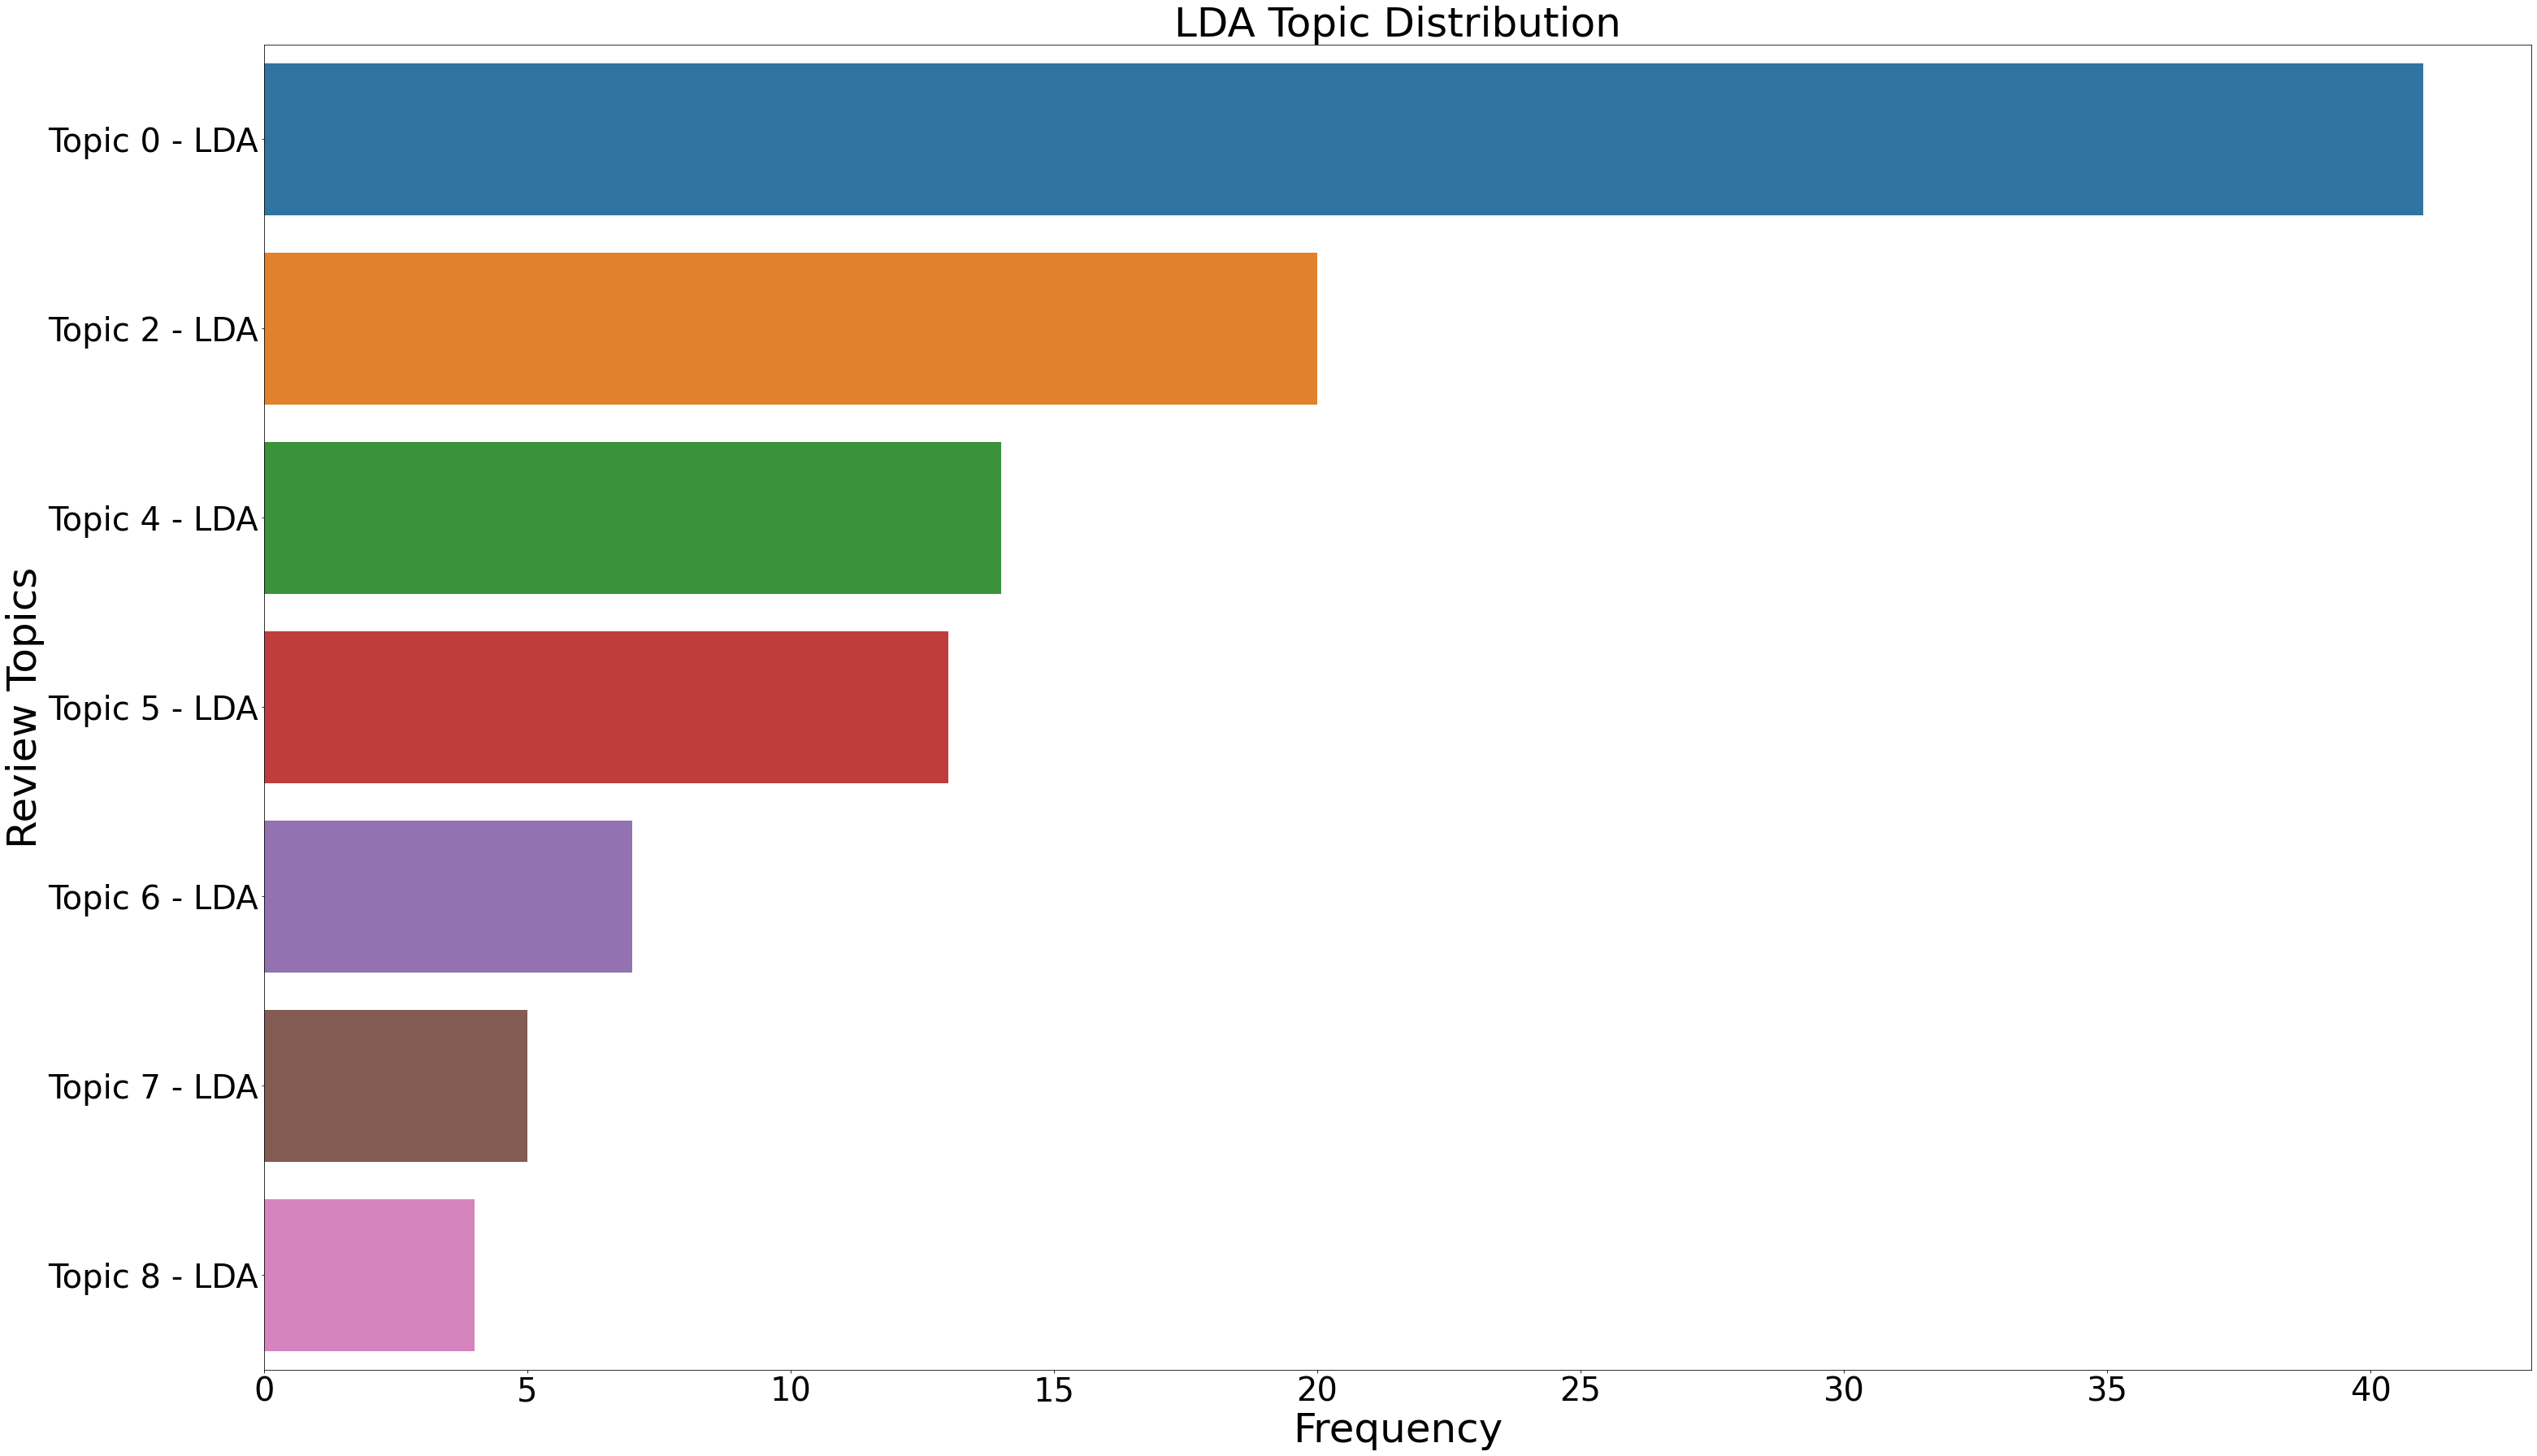

In [141]:
lda_x = processed['lda_topics'].value_counts()
lda_y = lda_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(lda_x, lda_y.index)
plt.title("LDA Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

In [142]:
processed

,stopwords_removedLoc,lemmatized,latLong,lemma_str,nmf_topics,lda_topics
0,"[houston, texas]","[2019, c.t, bauer, college, business, graduate...","(29.7589382, -95.3676974)",2019 c.t bauer college business graduate magna...,Topic 3 - NMF,Topic 4 - LDA
1,[kanada],"[native, english, teacher, epik, english, prog...","(61.0666922, -107.991707)",native english teacher epik english program korea,Topic 7 - NMF,Topic 7 - LDA
2,"[raleigh-durham, north, carolina]","[aspire, human, resource, professional]","(35.880361449999995, -78.78723821716514)",aspire human resource professional,Topic 0 - NMF,Topic 8 - LDA
3,"[denton, texas]","[people, development, coordinator, ryan]","(33.1838787, -97.1413417)",people development coordinator ryan,Topic 4 - NMF,Topic 4 - LDA
4,"[i̇zmir, türkiye]","[advisory, board, member, celal, bayar, univer...","(38.4224548, 27.1310699)",advisory board member celal bayar university,Topic 9 - NMF,Topic 0 - LDA
...,...,...,...,...,...,...
99,"[cape, girardeau, missouri]","[aspire, human, resource, manager, graduating,...","(37.3034933, -89.5230357)",aspire human resource manager graduating may 2...,Topic 6 - NMF,Topic 8 - LDA
100,"[raleigh-durham, north, carolina]","[human, resource, generalist, loparex]","(35.880361449999995, -78.78723821716514)",human resource generalist loparex,Topic 1 - NMF,Topic 8 - LDA
101,"[new, york, city]","[business, intelligence, analytics, traveler]","(40.7127281, -74.0060152)",business intelligence analytics traveler,Topic 3 - NMF,Topic 4 - LDA
102,"[los, angeles]","[always, set, success]","(34.0536909, -118.242766)",always set success,Topic 0 - NMF,Topic 0 - LDA


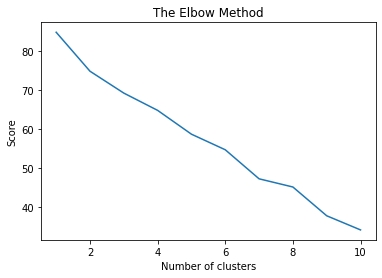

In [143]:
# set clusters to 10 ( To start with as a test )
k_clusters = 10

from sklearn.cluster import KMeans

score = []
for i in range(1,k_clusters + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
    kmeans.fit(doc_term_matrix_tfidf)
    score.append(kmeans.inertia_)
plt.plot(range(1,k_clusters + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('elbow.png')
plt.show()

In [146]:
k_clusters = 7

model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(doc_term_matrix_tfidf)

clusters = model.predict(X_train_vc)

NameError: name 'X_train_vc' is not defined